In [6]:
# WIP: this is doing some analysis on the data received, 
df = pd.read_csv("results/output.gz", compression='gzip')

df["metric_name"].value_counts()

df[df["metric_name"] == "data_received"]

/var/folders/_c/80pl6wz90tv_5125dfvvl54r0000gn/T/ipykernel_6792/3481217517.py:1: DtypeWarning: Columns (7) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("results/output.gz", compression='gzip')


,metric_name,timestamp,metric_value,check,error,error_code,expected_response,group,method,name,proto,scenario,service,status,subproto,tls_version,url,extra_tags,metadata
19,data_received,1751892239,432888.0,NaN,NaN,NaN,NaN,::setup,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
35,data_received,1751892240,47077.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nodeNeighboursWithPropsByName,NaN,NaN,NaN,NaN,NaN,NaN,NaN
51,data_received,1751892240,47077.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nodeNeighboursWithPropsByName,NaN,NaN,NaN,NaN,NaN,NaN,NaN
67,data_received,1751892240,47077.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nodeNeighboursWithPropsByName,NaN,NaN,NaN,NaN,NaN,NaN,NaN
83,data_received,1751892240,47077.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nodeNeighboursWithPropsByName,NaN,NaN,NaN,NaN,NaN,NaN,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
736162,data_received,1751892300,47077.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nodeNeighboursWithPropsByName,NaN,NaN,NaN,NaN,NaN,NaN,NaN
736168,data_received,1751892300,47077.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nodeNeighboursWithPropsByName,NaN,NaN,NaN,NaN,NaN,NaN,NaN
736174,data_received,1751892300,47077.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nodeNeighboursWithPropsByName,NaN,NaN,NaN,NaN,NaN,NaN,NaN
736180,data_received,1751892300,47077.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,nodeNeighboursWithPropsByName,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [13]:
from os import listdir
import pandas as pd


def process_file(path):
    iter_csv = pd.read_csv("results/" + path, iterator=True, chunksize=10_000, compression='gzip')
    output = pd.concat([chunk[["timestamp", "metric_name", "metric_value", "scenario"]] for chunk in iter_csv])
    # output = pd.read_csv("results/" + path, compression='gzip')
   
    output['timestamp'] = pd.to_datetime(output['timestamp'], unit='s')
    output = output.set_index('timestamp')

    def find_max_rate(scenario_name):
        scenario = output[output["scenario"] == scenario_name]
        req_duration = scenario[scenario["metric_name"] == "http_req_duration"]
        # avg = req_duration["metric_value"].resample('1s').mean()
        p95 = req_duration["metric_value"].resample('1s').quantile(0.95)
        # p99 = req_duration["metric_value"].resample('1s').quantile(0.99)
        rate = req_duration["metric_value"].resample('1s').count()

        vus = scenario[scenario["metric_name"] == "vus"]["metric_value"].resample('1s').mean()

        cols = {
            # 'avg': avg,
            'p95': p95,
            # 'p99': p99,
            'rate': rate,
            'vus': vus,
        }
        trend = pd.DataFrame(cols).iloc[10:].reset_index() # discard first 10 seconds
        
        valid_mask = trend["p95"] < 200 # 200ms
        invalid_mask = ~valid_mask
        zero_is_valid = invalid_mask.cumsum()
        valid_trend = trend[zero_is_valid == 0]
        return valid_trend["rate"].max()
        # max_rate_index = valid_trend["rate"].idxmax()
        # perf = valid_trend.loc[max_rate_index]
        # return pd.Series(perf, name=scenario_name)

    scenarios = output["scenario"].unique()[1:] # first element is nan
    max_rates = [find_max_rate(scenario) for scenario in scenarios]
    print(max_rates)
    return pd.Series(max_rates, name=path, index=scenarios)
    # perf = pd.concat((find_max_rate(scenario) for scenario in scenarios), axis=1).transpose()
    # return perf

pd.concat([process_file(file) for file in listdir("results")], axis=1)

[np.int64(4572), np.int64(4086), np.int64(5025)]
[np.int64(1638), np.int64(1915), np.int64(4788)]


,0.16.0.csv.gz,0.16.1b1.gz
writeRequest70percent,4572,1638
randomNodePage,4086,1915
nodeNeighboursByName,5025,4788


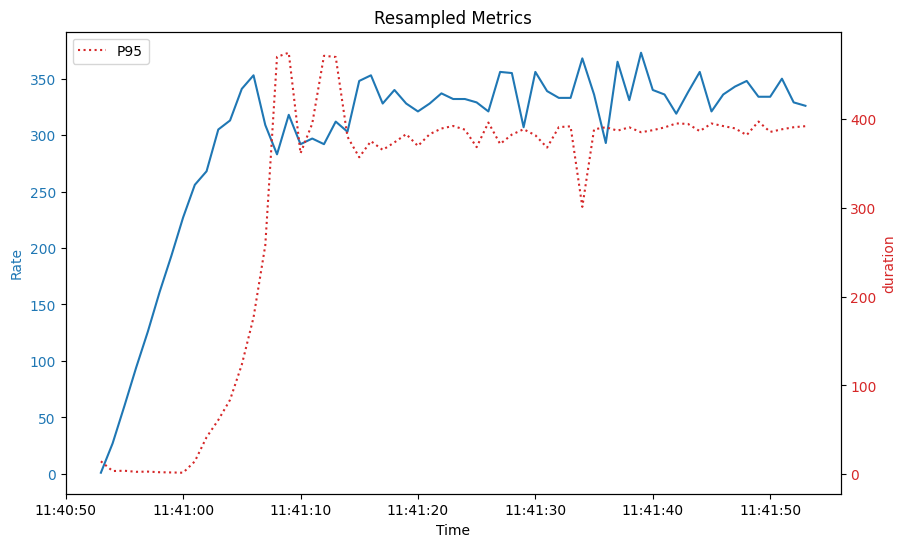

In [102]:
df = trend

fig, ax1 = plt.subplots(figsize=(10, 6))

color = 'tab:blue'
ax1.set_xlabel('Time')
ax1.set_ylabel('Rate', color=color)
ax1.plot(df.index, df['rate'], color=color)
ax1.tick_params(axis='y', labelcolor=color)

ax2 = ax1.twinx()

color = 'tab:red'
ax2.set_ylabel('duration', color=color)
# ax2.plot(df.index, df['avg'], color=color, linestyle='--', label='Avg')
ax2.plot(df.index, df['p95'], color=color, linestyle=':', label='P95')
# ax2.plot(df.index, df['p99'], color=color, linestyle='-.', label='P99')
ax2.tick_params(axis='y', labelcolor=color)

lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
ax2.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper left')

plt.title('Resampled Metrics')
plt.show()